In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn import tree
from sklearn.metrics import confusion_matrix
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pickle
from sklearn.model_selection import cross_val_score
import itertools
import math
import scipy.special
#Configuramos pandas para mostrarnos 20 filas
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)

In [2]:
def list_cobmination_columns(df,num_max_comb):
    list_cobmination_columns=[]
    df_columns = df.columns
    for i in range (1,min(num_max_comb,len(df_columns))+1):
        for _, j in enumerate(itertools.combinations(df_columns, i)):
            list_cobmination_columns.append(list(j))
    return list_cobmination_columns

In [3]:
 def validacion(model,X_train,y_train,X_test,y_test):
    t=datetime.datetime.now()    
    
    y_1=[1]*len(y_test)
    print('accuracy dummy 1 test', sum(y_1==y_test)/len(y_test))
    print(confusion_matrix(y_test, y_1))
    
    y_0=[0]*len(y_test)
    print('accuracy dummy 0 test', sum(y_0==y_test)/len(y_test))
    print(confusion_matrix(y_test, y_0))
    
    y_random = []
    for i in range(len(y_test)):
        n = random.randint(0,1)
        y_random.append(n)
    print('accuracy random test',sum(y_random==y_test)/len(y_test))
    print(confusion_matrix(y_test, y_random))
    
    y_pred_train=model.predict(X_train)
    print('accuracy model train',sum(y_pred_train==y_train)/len(y_train))
    print(confusion_matrix(y_train, y_pred_train))

    y_pred_test=model.predict(X_test)
    print('accuracy model test',sum(y_pred_test==y_test)/len(y_test))
    print(confusion_matrix(y_test, y_pred_test))
    
    #Predecimos que ocurrirá con las pólizas de test
    y_pred_test = model.predict(X_test)

    # Comprobamos los resultados
    print(classification_report(y_test, y_pred_test))

    # Medimos el posible sobreajuste comparando resultados sobre conjuntos de entrenamiento y test
    print('Precision en el set de Entrenamiento: {:.2f}'
         .format(model.score(X_train, y_train)))
    print('Precision en el set de test: {:.2f}'
         .format(model.score(X_test, y_test)))

    # Comparamos los resultados con el modelo dummy
    print('Modelo random proporcionado')
    p_positivo=sum(y_train)/len(y_train)
    print('Probabilidad de positivo', p_positivo)
    y_predicted_dummy=y_pred_test.copy()
    for i in range(0,len(y_test)):
        y_predicted_dummy[i]=random.choices([0,1], [1-p_positivo,p_positivo])[0]
    print('Predicción dummy con probabilidad positivo =',p_positivo)
    print(classification_report(y_test, y_predicted_dummy))
    
    # Sacamos un análisis de precision y recall de recurrencia para diferentes umbrales de probabilidad
    print('Análisis de precision y recall de positivos para diferentes umbrales de probabilidad')
    reporte_por_umbral_de_probabilidad=pd.DataFrame(columns=['Umbral de probabilidad', 'Precision', 'Recall'])
    for p in np.arange(0.5, 0.58, 0.01):
        report=classification_report(y_test, 1*(model.predict_proba(X_test).T[1]>=p),output_dict=True)
        reporte_por_umbral_de_probabilidad = reporte_por_umbral_de_probabilidad.append({'Umbral de probabilidad': p, 'Precision':report['1']['precision'], 'Recall':report['1']['recall']}, ignore_index=True)
    print(reporte_por_umbral_de_probabilidad) 
    
    t=datetime.datetime.now()-t
    print('Validacion del modelo terminada en ',t,' s')
    return

In [4]:
#Cargamos el fichero de cotizaciones seleccionando las columnas relevantes para el modelo
path='C:\\Users\\manuel.decesar\\Desktop\\data_labqt\\'
df=pd.read_csv(path+'WIKI_PRICES_212b326a081eacca455e13140d7bb9db.csv', sep=',')[['ticker','date','adj_close','adj_volume']]  
print(len(df))
#fijamos los tipos de datos
df['date']=pd.to_datetime(df['date'])
print(len(df))
metadata=pd.read_csv(path+'us_equities_meta_data.csv')
df = pd.merge(df, metadata[["ticker","sector"]], on="ticker")
print(len(df))

15389314
15389314
12274396


In [5]:
#Filtrar tickers sin suficiente volumen
#df=df.reset_index()
df_ticker_volume=np.log10(df.groupby(['ticker'])['adj_volume'].sum())
df=df[df['ticker'].isin(df_ticker_volume[df_ticker_volume>8.211].index)]
#Filtrar tickers sin suficientes cotizaciones
df_ticker_cot=np.log10(df.groupby(['ticker'])['adj_close'].count())
df=df[df['ticker'].isin(df_ticker_cot[df_ticker_cot>3.104].index)]
#Filtrar registros sin volumen
df=df[df['adj_close']>0]
#Filtro de fecha
df=df[df.date>='2001-01-01']
#Establecemos índice (ticker y fecha)
df=df.set_index(['ticker','date'])
print(len(df))
#df

7710723


(7.967, 8.496]      204
(8.496, 8.737]      204
(8.737, 8.93]       204
(8.93, 9.091]       204
(9.091, 9.252]      204
(9.252, 9.405]      204
(9.405, 9.612]      204
(9.612, 9.87]       204
(9.87, 10.185]      204
(10.185, 11.728]    204
Name: adj_volume, dtype: int64
total de tickers 2197
mediana de volumen ajustado por ticker 5383.999999999998


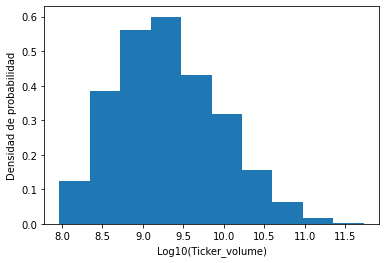

In [6]:
#Análisis volumen por ticker
%matplotlib inline
df_ticker_volume=np.log10(df.groupby(['ticker'])['adj_volume'].sum())
plt.hist(df_ticker_volume, density=True, bins=10)  # density=False would make counts
plt.ylabel('Densidad de probabilidad')
plt.xlabel('Log10(Ticker_volume)');
#percentiles
print(pd.qcut(df_ticker_volume,10).value_counts().sort_index())
print('total de tickers',len(df_ticker_cot))
print('mediana de volumen ajustado por ticker',10**df_ticker_cot.median())


(3.1047, 3.6201]     680
(3.6201, 3.6369]    1353
(3.6369, 3.637]        7
Name: adj_close, dtype: int64
mediana de número de cotizaciones por ticker 4333.999999999999


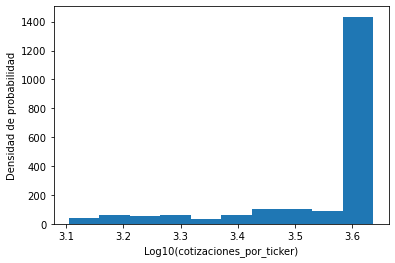

In [7]:
#Análisis cotizaciones por ticker
%matplotlib inline
df_ticker_cot=np.log10(df.groupby(['ticker'])['adj_close'].count())
plt.hist(df_ticker_cot, density=False, bins=10)  # density=False would make counts
plt.ylabel('Densidad de probabilidad')
plt.xlabel('Log10(cotizaciones_por_ticker)');
#percentiles
print(pd.qcut(df_ticker_cot,3).value_counts().sort_index())
print('mediana de número de cotizaciones por ticker',10**df_ticker_cot.median())

In [8]:
#Análisis nulos
print(df.reset_index()[df.reset_index().ticker.isnull()])
print(df.reset_index()[df.reset_index().date.isnull()])
print(df.reset_index()[df.reset_index().adj_close.isnull()])
print(df.reset_index()[df.reset_index().adj_volume.isnull()])

Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []


(0.999, 1498.0]     871
(1498.0, 1746.6]    865
(1746.6, 1918.0]    869
(1918.0, 2026.0]    887
(2026.0, 2040.0]    848
Name: adj_close, dtype: int64
número de fechas 4340
mediana de número de tickers por fecha 1802.0


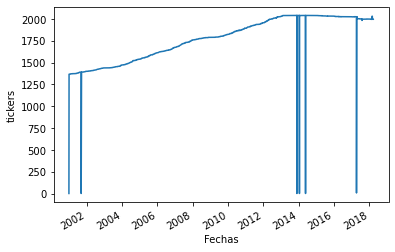

In [9]:
#Análisis discontinuidades de fechas
%matplotlib inline
df_date_tikers=df.groupby(['date'])['adj_close'].count()
df_date_tikers.plot()
plt.ylabel('tickers')
plt.xlabel('Fechas');
#percentiles
print(pd.qcut(df_date_tikers,5).value_counts().sort_index())
print('número de fechas',len(df_date_tikers))
print('mediana de número de tickers por fecha',df_date_tikers.median())

In [10]:
#tickers posibles
print(np.unique(df.index.get_level_values(0)))
#fechas posibles
print(np.unique(df.index.get_level_values(1)))

['A' 'AAL' 'AAN' ... 'ZNGA' 'ZTS' 'ZUMZ']
['2001-01-01T00:00:00.000000000' '2001-01-02T00:00:00.000000000'
 '2001-01-03T00:00:00.000000000' ... '2018-03-23T00:00:00.000000000'
 '2018-03-26T00:00:00.000000000' '2018-03-27T00:00:00.000000000']


In [11]:
#Filtrar muestra para desarrollo
#df=df.sort_values(by=['date'], ascending=True)[0:int(len(df)*0.8)]
df=df.sort_values(by=['ticker'], ascending=False)[0:200000]
df=df.sort_values(by=['ticker','date'])
df=df.reset_index()
df=df.set_index(['ticker','date'])
print(len(df))

200000


In [12]:
#dummies para el sector
print(df.sector.unique())
df = pd.get_dummies(data=df, columns=['sector'])
pickle.dump(df.columns, open(path+'columnas', 'wb'))
print(datetime.datetime.now(),': Extraido fichero de transformación en dummies: columnas')
columnas=pickle.load(open(path+'columnas', 'rb'))
print(columnas)
df=df.reindex(labels =columnas, axis = 1, fill_value = 0)
df

['Capital Goods' 'Technology' 'Energy' 'Finance' nan 'Consumer Services'
 'Consumer Durables' 'Basic Industries' 'Public Utilities' 'Miscellaneous'
 'Consumer Non-Durables' 'Health Care' 'Transportation']
2022-01-05 10:47:33.875449 : Extraido fichero de transformación en dummies: columnas
Index(['adj_close', 'adj_volume', 'sector_Basic Industries',
       'sector_Capital Goods', 'sector_Consumer Durables',
       'sector_Consumer Non-Durables', 'sector_Consumer Services',
       'sector_Energy', 'sector_Finance', 'sector_Health Care',
       'sector_Miscellaneous', 'sector_Public Utilities', 'sector_Technology',
       'sector_Transportation'],
      dtype='object')


adj_close  adj_volume  sector_Basic Industries  \
ticker date                                                         
WOR    2001-01-02   4.596238    272900.0                        0   
       2005-04-28  11.161708    736200.0                        0   
       2005-04-29  11.328925    768500.0                        0   
       2005-05-02  11.349827    668500.0                        0   
       2005-05-03  11.447370    843100.0                        0   
       2005-05-04  11.565815    601000.0                        0   
       2005-05-05  11.447370    687000.0                        0   
       2005-05-06  11.712130    450000.0                        0   
       2005-05-09  11.628521    389600.0                        0   
       2005-05-10  11.308023    317800.0                        0   
...                      ...         ...                      ...   
ZUMZ   2018-03-14  19.600000    357345.0                        0   
       2018-03-15  20.000000    599736.0                        0   
       2018-03-16  22.100000   2059778.0                        0   
       2018-03-19  23.400000    858257.0                        0   
       2018-03-20  23.800000    404873.0                        0   
       2018-03-21  23.950000    354092.0                        0   
       2018-03-22  23.350000    269607.0                        0   
       2018-03-23  23.550000    301584.0                        0   
       2018-03-26  24.650000    375320.0                        0   
       2018-03-27  23.600000    403884.0                        0   

                   sector_Capital Goods  sector_Consumer Durables  \
ticker date                                                         
WOR    2001-01-02                     1                         0   
       2005-04-28                     1                         0   
       2005-04-29                     1                         0   
       2005-05-02                     1                         0   
       2005-05-03                     1                         0   
       2005-05-04                     1                         0   
       2005-05-05                     1                         0   
       2005-05-06                     1                         0   
       2005-05-09                     1                         0   
       2005-05-10                     1                         0   
...                                 ...                       ...   
ZUMZ   2018-03-14                     0                         0   
       2018-03-15                     0                         0   
       2018-03-16                     0                         0   
       2018-03-19                     0                         0   
       2018-03-20                     0                         0   
       2018-03-21                     0                         0   
       2018-03-22                     0                         0   
       2018-03-23                     0                         0   
       2018-03-26                     0                         0   
       2018-03-27                     0                         0   

                   sector_Consumer Non-Durables  sector_Consumer Services  \
ticker date                                                                 
WOR    2001-01-02                             0                         0   
       2005-04-28                             0                         0   
       2005-04-29                             0                         0   
       2005-05-02                             0                         0   
       2005-05-03                             0                         0   
       2005-05-04                             0                         0   
       2005-05-05                             0                         0   
       2005-05-06                             0                         0   
       2005-05-09                             0                         0

In [13]:
#Calculamos el retorno respecto al día anterior: incremento relativo del ticker respecto el día anterior
df['return_d']=df.groupby(level='ticker')['adj_close'].pct_change()
#Calculamos el retorno respecto a la semana anterior: incremento relativo del ticker respecto a la semana anterior
df['return_w']=df.groupby(level='ticker')['adj_close'].pct_change(periods=5)
#Calculamos el retorno respecto al mes anterior: incremento relativo del ticker respecto el mes anterior
df['return_m']=df.groupby(level='ticker')['adj_close'].pct_change(periods=20)
#Calculamos el retorno respecto al año anterior: incremento relativo del ticker respecto el año anterior
df['return_y']=df.groupby(level='ticker')['adj_close'].pct_change(periods=252)
#df

In [14]:
#Volatilidad semanal del retorno diario
df['volatility_w_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_d'].rolling(5).std())
#Volatilidad mensual del retorno diario
df['volatility_m_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_m'].rolling(20).std())
#Volatilidad anual del retorno diario
df['volatility_y_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_y'].rolling(252).std())
#df

In [15]:
#Cierre ajustado promediado semanal
df['adj_close_m_pw']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.rolling(5).mean())
#Cierre ajustado promediado mensual
df['adj_close_m_pm']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.rolling(20).mean())
#Cierre ajustado promediado anual
df['adj_close_m_py']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.rolling(252).mean())

In [16]:
#Retorno respecto al cierre ajustado promediado semanal
df['return_m_pw']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_pw'])/x['adj_close_m_pw'], axis=1)
#Retorno respecto al cierre ajustado promediado mensual
df['return_m_pm']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_pm'])/x['adj_close_m_pm'], axis=1)
#Retorno respecto al cierre ajustado promediado anual
df['return_m_py']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_py'])/x['adj_close_m_py'], axis=1)

In [17]:
#Equivalente a macd para un día y una semana
#Cierre ajustado promediado ponderado por volumen semanal
df['adj_close_vwm_pw']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).rolling(5).sum()/grp['adj_volume'].rolling(5).sum())
#Cierre ajustado promediado ponderado por volumen mensual
df['adj_close_vwm_pm']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).rolling(20).sum()/grp['adj_volume'].rolling(20).sum())
#Cierre ajustado promediado ponderado por volumen anual
df['adj_close_vwm_py']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).rolling(252).sum()/grp['adj_volume'].rolling(252).sum())
#df.loc['X']

In [18]:
#Filtramos NaN
print(len(df))
df=df.dropna()
df=df.reset_index()
df=df.set_index(['ticker','date'])
print(len(df))

200000
172231


In [19]:
#Retorno respecto al cierre ajustado promediado ponderado semanal
df['return_vwm_pw']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_pw'])/x['adj_close_vwm_pw'], axis=1)
df#Retorno respecto al cierre ajustado promediado ponderado mensual
df['return_vwm_pm']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_pm'])/x['adj_close_vwm_pm'], axis=1)
df#Retorno respecto al cierre ajustado promediado ponderado anual
df['return_vwm_py']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_py'])/x['adj_close_vwm_py'], axis=1)
#df

In [20]:
#Calculamos el retorno al día siguiente: incremento relativo del ticker en el día siguiente
df['return_f_d']=df.groupby(level='ticker')['adj_close'].pct_change().shift(periods=-1)

In [21]:
#Calculamos target (retorno>0)
df['return_gt_0']=df.apply(lambda x: 1 if x['return_f_d']>0 else 0, axis=1)

In [77]:
#Calculamos el peso como el valor absoluto del retorno al día siguiente (retorno>0)
df['sample_weight']=df.apply(lambda x:abs(x['return_f_d'])**(1/8), axis=1)

In [78]:
#Filtramos NaN
print(len(df))
df=df.dropna()
df=df.reset_index()
df=df.set_index(['ticker','date'])
print(len(df))

172176
172176


In [94]:
#Preparamos datasets de train, validation, test, final_test
df=df.sort_values('date')
lim_train=int(len(df)*.4)
lim_val=int(len(df)*.41)
lim_test=int(len(df)*.42)
df_train= df[0:lim_train]
df_val=df[lim_train:lim_val]
df_train_val= df[0:lim_val]
df_test= df[lim_val:lim_test]
df_final_test= df[lim_test:-1]
total_features=['return_d','return_w','return_m','return_y','return_m_pw','return_m_pm','return_m_py','volatility_w_rd','volatility_m_rd','volatility_y_rd','return_vwm_pw','return_vwm_pm','return_vwm_py','sector_Basic Industries',
       'sector_Capital Goods', 'sector_Consumer Non-Durables',
       'sector_Consumer Services', 'sector_Energy', 'sector_Finance',
       'sector_Health Care', 'sector_Public Utilities', 'sector_Technology',
       'sector_Transportation']
target=['return_gt_0']
sample_weight=['sample_weight']

In [95]:
#modelos
modelos=[]

In [104]:
#Construimos un modelo de árbol de decisión con cv de features y profundidad
tiempo_busqueda=10 #en segundos
max_depth=100
max_features=100
#mask=['return_d', 'sector_Energy','return_y','return_m_py', 'return_vwm_py','return_m','volatility_y_rd', 'return_w']
#mask=['return_d', 'return_w', 'return_y', 'volatility_w_rd', 'volatility_m_rd','sector_Consumer Services']
#mask=['return_d', 'return_w', 'return_y', 'volatility_w_rd', 'volatility_m_rd','sector_Consumer Services','return_m_py', 'return_vwm_py','return_m','volatility_y_rd']
mask=total_features
#Estrategia random val
s=df_val.groupby('date')['return_f_d'].mean()
rcs_random_val=(((s+1).cumprod())[-2:-1]-1).values[0] if len(s)>1 else 0
print('Retorno random validacion',rcs_random_val)
#Estrategia random train
s=df_train.groupby('date')['return_f_d'].mean()
rcs_random_train=(((s+1).cumprod())[-2:-1]-1).values[0] if len(s)>1 else 0
print('Retorno random train',rcs_random_train)
#Selección de features y profundidad con cv
t=datetime.datetime.now()
depths=range(1,max_depth+1)
opt_depth=0
accuracy_cv=0.5
opt_features=[]
rcs_opt=rcs_random
metric=-1000000
tt=datetime.datetime.now()
for i in depths:
    if (datetime.datetime.now()-tt).seconds>tiempo_busqueda:
        break
    print('depth',i)
    for features in list_cobmination_columns(df_train[mask],min(max_features, (2**i)-1)):
        if (datetime.datetime.now()-tt).seconds>tiempo_busqueda:
            break
        model = tree.DecisionTreeClassifier(max_depth=i)
        #metricas para el caso
        model = model.fit(df_train[features], df_train[target],sample_weight=df_train.sample_weight.values)
        s=(df_train[[ True if x==1 else False for x in model.predict(df_train[features])]]).groupby('date')['return_f_d'].mean()
        rcs_train=(((s+1).cumprod())[-2:-1]-1).values[0] if len(s)>1 else 0
        s=(df_val[[ True if x==1 else False for x in model.predict(df_val[features])]]).groupby('date')['return_f_d'].mean()
        rcs_val=(((s+1).cumprod())[-2:-1]-1).values[0] if len(s)>1 else 0
        #print(features,rcs)
        if metric < rcs_train:
            metric=rcs_train
            opt_depth=i
            opt_features=features
            accuracy_opt=sum(model.predict(df_train[features])==df_train.return_gt_0.values)/len(df_train[target])
            print('features_encontrados',opt_features,'Retorno validacion',rcs_val,'Retorno train',rcs_train,'Profundidad encontrada',opt_depth,'accuracy encontrada',accuracy_opt)
t=datetime.datetime.now()-t
print('Selección de hiperparámetros terminada en ',t,' s')

#Validation
print('Validation')


model = tree.DecisionTreeClassifier(max_depth=opt_depth)
model = model.fit(df_train[opt_features], df_train[target],sample_weight=df_train.sample_weight.values)
modelos.append(model)

accuracy_train=sum(model.predict(df_train[opt_features])==df_train.return_gt_0.values)/len(df_train[target])
s=(df_train[[ True if x==1 else False for x in model.predict(df_train[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_train=(((s+1).cumprod())[-2:-1]-1).values[0] if len(s)>1 else 0
accuracy_val=sum(model.predict(df_val[opt_features])==df_val.return_gt_0.values)/len(df_val[target])
s=(df_val[[ True if x==1 else False for x in model.predict(df_val[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_val=(((s+1).cumprod())[-2:-1]-1).values[0] if len(s)>1 else 0
print('Features optimos',opt_features,'Retorno en validation',rcs_val,'Retorno en train',rcs_train,'Profundidad optima',opt_depth,'accuracy_val',accuracy_val,'accuracy_train',accuracy_train)

y_pred_train=model.predict(df_train[opt_features])
y_train=df_train.return_gt_0.values
print('accuracy model train',sum(y_pred_train==y_train)/len(y_train))
print(confusion_matrix(y_train, y_pred_train))

y_pred_val=model.predict(df_val[opt_features])
y_val=df_val.return_gt_0.values
print('accuracy model val',sum(y_pred_val==y_val)/len(y_val))
print(confusion_matrix(y_val, y_pred_val))
#validacion(model,df_train[opt_features], df_train[target].values,df_val[opt_features], df_val[target].values)      

#Estrategia random test
s=df_test.groupby('date')['return_f_d'].mean()
rcs_random=(((s+1).cumprod())[-2:-1]-1).values[0] if len(s)>1 else 0
print('Retorno final acumulado test',rcs_random)

#Test
print('Test')
model = tree.DecisionTreeClassifier(max_depth=opt_depth)
model = model.fit(df_train_val[opt_features], df_train_val[target],sample_weight=df_train_val.sample_weight.values)
modelos.append(model)

accuracy_test=sum(model.predict(df_test[opt_features])==df_test.return_gt_0.values)/len(df_test[target])
accuracy_train_val=sum(model.predict(df_train_val[opt_features])==df_train_val.return_gt_0.values)/len(df_train_val[target])
s=(df_test[[ True if x==1 else False for x in model.predict(df_test[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_test=(((s+1).cumprod())[-2:-1]-1).values[0] if len(s)>1 else 0
s=(df_train_val[[ True if x==1 else False for x in model.predict(df_train_val[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_train_val=(((s+1).cumprod())[-2:-1]-1).values[0] if len(s)>1 else 0
print('Features optimos',opt_features,'Retorno en test',rcs_test,'Retorno en train_val',rcs_train_val,'Profundidad optima',opt_depth,'accuracy_test',accuracy_test,'accuracy_train_val',accuracy_train_val)

y_pred_val=model.predict(df_train_val[opt_features])
y_val=df_train_val.return_gt_0.values
print('accuracy model train_val',sum(y_pred_val==y_val)/len(y_val))
print(confusion_matrix(y_val, y_pred_val))

y_pred_test=model.predict(df_test[opt_features])
y_test=df_test.return_gt_0.values
print('accuracy model test',sum(y_pred_test==y_test)/len(y_test))
print(confusion_matrix(y_test, y_pred_test))
#validacion(model,df_val[opt_features], df_val[target].values,df_test[opt_features], df_test[target].values)



Retorno random validacion 0.02424460742794543
Retorno random train 1.6704134885455413
depth 1
features_encontrados ['return_d'] Retorno validacion 0.03360265742854662 Retorno train 14.369583764709684 Profundidad encontrada 1 accuracy encontrada 0.5191810657760999
depth 2
features_encontrados ['return_d', 'return_w'] Retorno validacion 0.041584715009973294 Retorno train 17.31729944395357 Profundidad encontrada 2 accuracy encontrada 0.5199215914040947
features_encontrados ['return_d', 'return_m_pw'] Retorno validacion 0.04206642945397765 Retorno train 37.46064089498479 Profundidad encontrada 2 accuracy encontrada 0.5211412806737331
Selección de hiperparámetros terminada en  0:00:11.012368  s
Validation
Features optimos ['return_d', 'return_m_pw'] Retorno en validation 0.04206642945397765 Retorno en train 37.46064089498479 Profundidad optima 2 accuracy_val 0.48664343786295006 accuracy_train 0.5211412806737331
accuracy model train 0.5211412806737331
[[21525 13490]
 [19489 14366]]
accuracy 

In [42]:
#Modelo logistic regression
model =  LogisticRegression(random_state=0).fit(X_train, y_train)
modelos.append(model)

validacion(model,X_train,y_train,X_test,y_test)

accuracy dummy 1 test 0.5070653767223688
[[   0 8407]
 [   0 8648]]
accuracy dummy 0 test 0.4929346232776312
[[8407    0]
 [8648    0]]
accuracy random test 0.5048372911169745
[[4214 4193]
 [4252 4396]]
accuracy train 0.5202714587242027
[[24071 10631]
 [22098 11424]]
accuracy test 0.5047200234535327
[[5922 2485]
 [5962 2686]]
              precision    recall  f1-score   support

           0       0.50      0.70      0.58      8407
           1       0.52      0.31      0.39      8648

    accuracy                           0.50     17055
   macro avg       0.51      0.51      0.49     17055
weighted avg       0.51      0.50      0.48     17055

Precision en el set de Entrenamiento: 0.52
Precision en el set de test: 0.50
Predicción dummy con probabilidad positivo = 0.49135201688555347
              precision    recall  f1-score   support

           0       0.49      0.52      0.50      8407
           1       0.50      0.48      0.49      8648

    accuracy                           

C:\Users\manuel.decesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\manuel.decesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\manuel.decesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\manuel.decesar\anac

In [44]:
#Modelo de vecinos más cercanos
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
modelos.append(model)

validacion(model,X_train,y_train,X_test,y_test)

accuracy dummy 1 test 0.5070653767223688
[[   0 8407]
 [   0 8648]]
accuracy dummy 0 test 0.4929346232776312
[[8407    0]
 [8648    0]]
accuracy random test 0.5065376722368807
[[4230 4177]
 [4239 4409]]
accuracy model train 1.0
[[34702     0]
 [    0 33522]]
accuracy model test 0.5038405159777192
[[4294 4113]
 [4349 4299]]
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      8407
           1       0.51      0.50      0.50      8648

    accuracy                           0.50     17055
   macro avg       0.50      0.50      0.50     17055
weighted avg       0.50      0.50      0.50     17055

Precision en el set de Entrenamiento: 1.00
Precision en el set de test: 0.50
Predicción dummy con probabilidad positivo = 0.49135201688555347
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      8407
           1       0.51      0.50      0.51      8648

    accuracy                           0.5

Retornos diarios


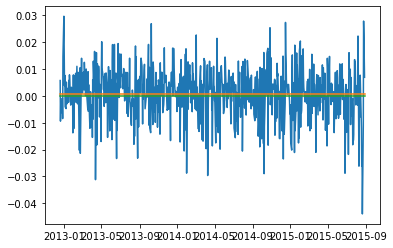

Retornos diarios acumulados sin reinvertir


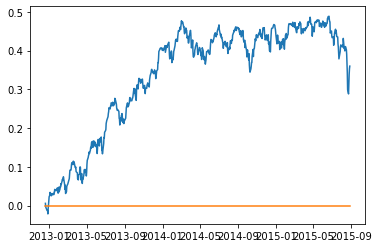

Retornos diarios acumulados reinvirtiendo


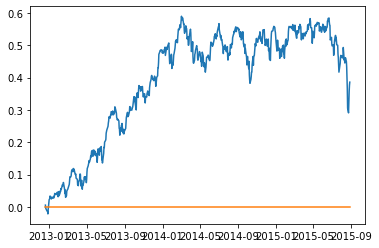

Retorno final acumulado 0.3761804038028591


In [30]:
#Retornos diarios estrategia dummy (estrategia de repartir a partes iguales entre todos los tickers diariamente)
s=df_test.groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()
print('Retorno final acumulado',(rcs[-2:-1]-1).values[0])

<ipython-input-31-9f2d82d1d8ca>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s=df_test[df['return_d']>0].groupby('date')['return_f_d'].mean()


Retornos diarios


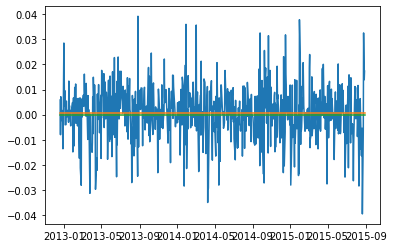

Retornos diarios acumulados sin reinvertir


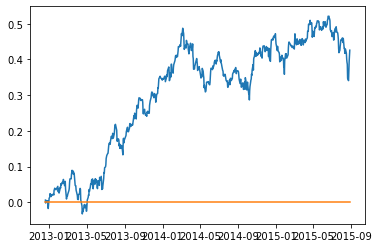

Retornos diarios acumulados reinvirtiendo


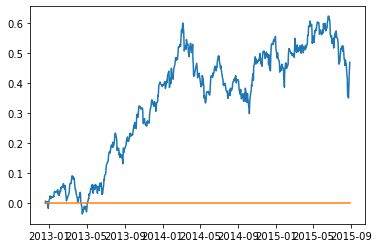

Retorno final acumulado 0.44422603129891636


In [31]:
#Retornos diarios estrategia básica (estrategia de repartir diariamente a partes iguales entre todos los tickers con retorno positivo respecto al día anterior)
s=df_test[df['return_d']>0].groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()
print('Retorno final acumulado',(rcs[-2:-1]-1).values[0])

In [29]:
#Retornos diarios modelo básico (estrategia de repartir diariamente a partes iguales entre todos los tickers predichos con retorno positivo al día siguiente)
s=((df[lim:-1])[[ True if x==1 else False for x in modelos[-1].predict(df_test[opt_features])]]).groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()
print('Retorno final acumulado',(rcs[-2:-1]-1).values[0])

NameError: name 'lim' is not defined

In [33]:
opt_features

['volatility_m_rd', 'volatility_y_rd', 'return_vwm_pw']

Retornos diarios


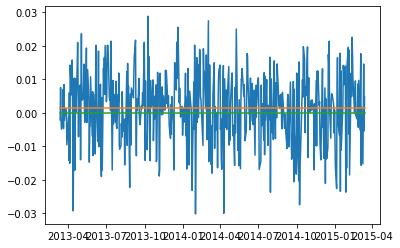

Retornos diarios acumulados sin reinvertir


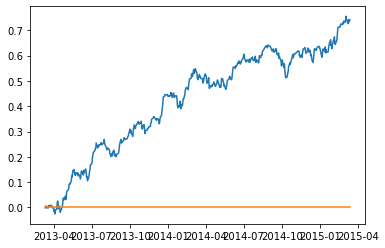

Retornos diarios acumulados reinvirtiendo


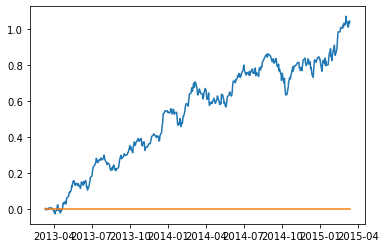

Retorno final acumulado 1.0309885528483735


In [29]:
#Retornos diarios modelo básico (estrategia de repartir diariamente a partes iguales entre todos los tickers predichos con retorno positivo al día siguiente)
s=((df[lim:-1])[[ True if x==1 else False for x in modelos[-1].predict(df_test[opt_features])]]).groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()
print('Retorno final acumulado',(rcs[-2:-1]-1).values[0])

<ipython-input-58-1867de095c6d>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s=(df[lim:-1])[df['return_f_d']>0].groupby('date')['return_f_d'].mean()


Retornos diarios


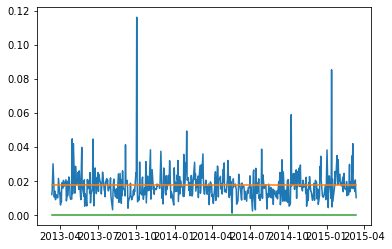

Retornos diarios acumulados sin reinvertir


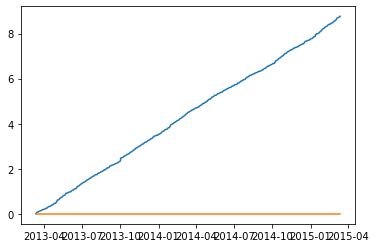

Retornos diarios acumulados reinvirtiendo


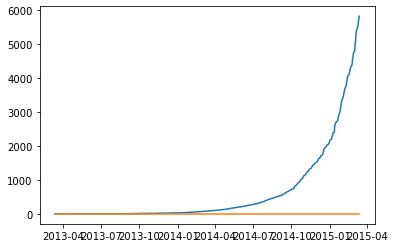

Retorno final acumulado 5767.022805915304


In [58]:
#Retornos diarios estrategia dios  (estrategia de repartir diariamente a partes iguales entre todos los tickers que tendrán retorno positivo (supone conocer el futuro))
s=(df[lim:-1])[df['return_f_d']>0].groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()
print('Retorno final acumulado',(rcs[-2:-1]-1).values[0])

Siguiente:
Testear modelo

features: día de la semana, zscore del precio (power point)

more comlex model 

marcar features con x_ y target con y_ para luego seleccionarlas (como en ejemplo de Manu)

#Zscore (normalizar? por día? para todos los tickets?)
#df['zscore']=df.groupby('date')['adj_close'].transform(lambda grp: (grp - grp.mean())/ grp.std())
#df
